In [7]:

from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#define a function for determining the values of params of cannny by cv2.threshold
def high_low_thresh(img):
    high_thresh,thresh_img=cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    low_thresh=0.5*high_thresh
    return [low_thresh,high_thresh]
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
  
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#use np.polyfit to average the line segments detected by canny
def slope_c(xs,ys):      
    return np.polyfit(xs,ys,1)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):

    #define two array for hold the right/left lines mid-points for np.pollyfit to average
    ll=[]
    rl=[]
    
    #get the size of image
    image_h=img.shape[0]
    image_w=img.shape[1]
            
    #collect the mid_points of lines on the left
    for line in lines:
        for x1,y1,x2,y2 in line:
            if((x2-x1)==0.0):
                continue
            #the points of lines on the left are less than x of mid_points of impage width
            #and the slope of line is less than zero
            if((y2-y1)*(x2-x1)<0 and (x2-image_w/2)<0 and (x1-image_w/2)<0):
                ll.append([x1,y1])
                ll.append([x2,y2])
    #collect the mid_points of lines on the right
    for line in lines:
        for x1,y1,x2,y2 in line:          
            if(x2-x1==0.0):
                continue
            #the points of lines on the left are less than x of mid_points of impage width
            #and the slope of line is more than zero
            if((y2-y1)*(x2-x1)>0 and (x2-image_w/2)>0 and (x1-image_w/2)>0):
                rl.append([x1,y1])
                rl.append([x2,y2])
                
    if(ll and rl):
        #return the slope and points of left/right lines averaged
        fll=cv2.fitLine(np.array(ll),cv2.cv.CV_DIST_L2,0,1,1)
        flr=cv2.fitLine(np.array(rl),cv2.cv.CV_DIST_L2,0,1,1)
        
        #draw the left lines averaged
        vx=fll[0][0]
        vy=fll[1][0]
        x0=fll[2][0]
        y0=fll[3][0] 
        if(vx):
            lslope=vy/vx
            lc=y0-x0*lslope
            lx1=(image_h-lc)/lslope    
            lx2=(image_h/2+50-lc)/lslope
            cv2.line(img, (int(lx1), int(image_h)), (int(lx2), int(image_h/2+50)), color, thickness)  
        
        #draw the right lines averaged
        vx=flr[0][0]
        vy=flr[1][0]
        x0=flr[2][0]
        y0=flr[3][0] 
        if(vx):
            rslope=vy/vx
            rc=y0-x0*rslope
            rx1=(image_h-rc)/rslope    
            rx2=(image_h/2+50-rc)/rslope
            cv2.line(img, (int(rx1), int(image_h)), (int(rx2), int(image_h/2+50)), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, a=0.8,  b=1.0, n=0.0):
    
    return cv2.addWeighted(initial_img, a, img, b, n)

This image is: <type 'numpy.ndarray'> with dimensions: (540L, 960L, 3L)


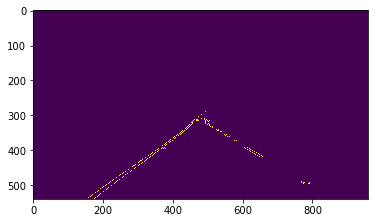

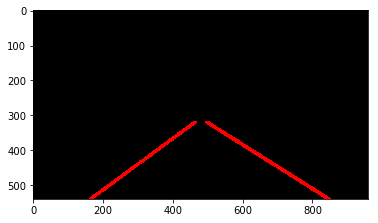

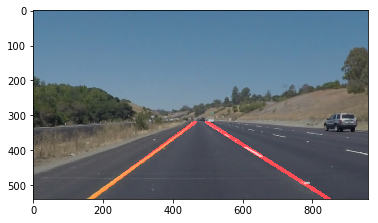

<function __main__.pipline_test>

In [8]:
#define a pipline_test to determint the values of params to find the lane line on the road accurately
def pipline_test(kernel_size,rho,threshold, min_line_len, max_line_gap):

    image = mpimg.imread('test_images/solidYellowCurve.jpg')
    initial_img=np.copy(image)
    
    #determine the intereting section of image
    x1=50
    y1=image.shape[0]    
    x2=image.shape[1]-50
    y2=image.shape[0]
    x3=image.shape[1]/2-20
    y3=image.shape[0]/2+20
    x4=image.shape[1]/2+20
    y4=image.shape[0]/2+20   
    vertices=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
        
    gimage=grayscale(image)
    gbimage=cv2.GaussianBlur(gimage, (kernel_size, kernel_size), 0,0)
    
    low_threshold,high_threshold=high_low_thresh(gbimage)
    
    bcimage=canny(gbimage,low_threshold, high_threshold)
    amimage=region_of_interest(bcimage,[vertices])

    himage=hough_lines(amimage,rho,np.pi/180,threshold, min_line_len, max_line_gap)
    wimage=weighted_img(himage,initial_img)

    plt.imshow(amimage)
    plt.show()
    plt.imshow(himage)
    plt.show()
    plt.imshow(wimage)
    plt.show()

#adjust the params visually,interatly by ipywidgets 
interact(pipline_test,
         kernel_size=widgets.IntSlider(min=1,max=100,step=2,value=5),
         rho=widgets.IntSlider(min=1,max=9,step=2,value=3),
         threshold=widgets.IntSlider(min=1,max=200,step=1,value=3),
         min_line_len=widgets.IntSlider(min=1,max=100,step=2,value=10), 
          max_line_gap=widgets.IntSlider(min=1,max=200,step=2,value=20))

['test_images/whiteCarLaneSwitch.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowLeft.jpg']
whiteCarLaneSwitch_processed.jpg


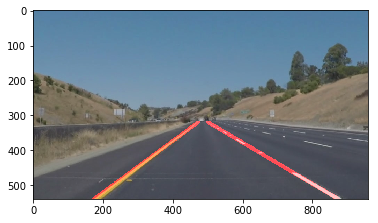

solidYellowCurve_processed.jpg


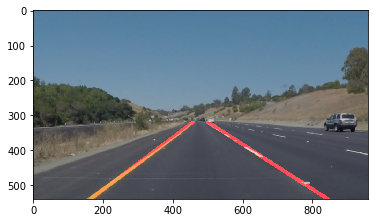

solidWhiteCurve_processed.jpg


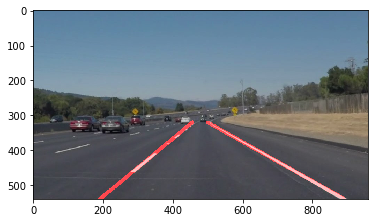

solidWhiteRight_processed.jpg


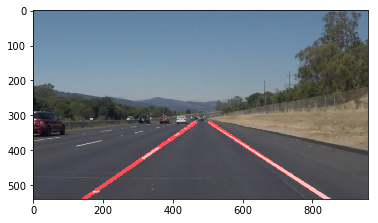

solidYellowLeft_processed.jpg


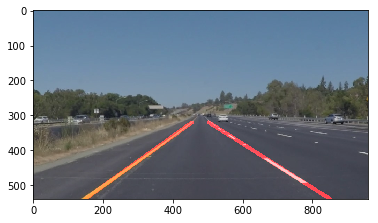

In [11]:
#define the last version of pipline function
def pipline(initial_img,image,kernel_size,rho,theta,threshold,min_line_len,max_line_gap):    
    
    x1=50
    y1=image.shape[0]    
    x2=image.shape[1]-50
    y2=image.shape[0]
    x3=image.shape[1]/2-20
    y3=image.shape[0]/2+20
    x4=image.shape[1]/2+20
    y4=image.shape[0]/2+20

    vertices=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
        
    gimage=grayscale(image)
    gbimage=cv2.GaussianBlur(gimage, (kernel_size, kernel_size), 0,0)
    
    low_threshold,high_threshold=high_low_thresh(gbimage)
    
    bcimage=canny(gbimage,low_threshold, high_threshold)
    amimage=region_of_interest(bcimage,[vertices])

    himage=hough_lines(amimage,rho,theta,threshold,min_line_len,max_line_gap)
    wimage=weighted_img(himage,initial_img)
    return wimage

#to test the images in test_images folder by last version of pipline
initial_imgs_dict={}
for fs in ( os.path.join("test_images/",f) for f in os.listdir("test_images/")):
    
    dup_check=fs.split('.')[0][-9:]
    
    if(len(dup_check)<9):
        initial_imgs_dict[fs]=mpimg.imread(fs)
    else:
        if dup_check!= "processed":
            initial_imgs_dict[fs]=mpimg.imread(fs)
print(initial_imgs_dict.keys())

for image_name in initial_imgs_dict.keys():
    initial_img=initial_imgs_dict[image_name]
    image=np.copy(initial_img)
    img_processed=pipline(initial_img,image,5,190,2*np.pi/180,3,10,20)
    
   #write the images for test to 'test_images/' by adding the 'processed' to the name
    cv2.imwrite(image_name.split('.')[0]+"_processed."+image_name.split('.')[1],img_processed)
    #show the images processed with the names
    print (image_name.split('/')[1].split('.')[0]+"_processed."+image_name.split('.')[1])
    plt.imshow(img_processed)
    plt.show()

In [16]:
def process_image(img):
    initial_img=np.copy(img)
    kernel_size=5
    rho=190
    theta=2*np.pi/180
    threshold=3
    min_line_len=10
    max_line_gap=20
    return  pipline(initial_img,img,kernel_size,rho,theta,threshold,min_line_len,max_line_gap)

In [17]:
white_output = 'white-me.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white-me.mp4
[MoviePy] Writing video white-me.mp4


100%|███████████████████████████████████████▊| 221/222 [00:08<00:00, 26.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white-me.mp4 

Wall time: 9.47 s


In [19]:
yellow_output = 'yellow-me.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow-me.mp4
[MoviePy] Writing video yellow-me.mp4


100%|███████████████████████████████████████▉| 681/682 [00:28<00:00, 23.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow-me.mp4 

Wall time: 29.9 s
